In [50]:
import matplotlib.pyplot as plt
import fastf1.plotting
import fastf1
import pandas as pd

fastf1.plotting.setup_mpl(misc_mpl_mods = False)

In [51]:
# load the session
session = fastf1.get_session(2021, 'Spanish Grand Prix', 'Q')
session.load()

core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.1.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '31', '55', '3', '11', '4', '14', '18', '10', '5', '99', '63', '22', '7', '47', '6', '9']


In [65]:
# pick the fastest lap for each driver
lec_lap = session.laps.pick_driver('LEC').pick_fastest()
ham_lap = session.laps.pick_driver('HAM').pick_fastest()

In [66]:
# add the distance column to the telemetry data
lec_tel = lec_lap.get_car_data().add_distance()
ham_tel = ham_lap.get_car_data().add_distance()

In [67]:
# get the circuit information object
circuit_info = session.get_circuit_info()
# get the corners data frame
corners = circuit_info.corners
corners = corners[['Distance', 'Number']]
corners

,Distance,Number
0,840.439503,1
1,925.219271,2
2,1168.211321,3
3,1741.685572,4
4,2122.736857,5
5,2364.579753,6
6,2547.543141,7
7,2637.109590,8
8,2925.381432,9
9,3499.034859,10


In [68]:
# Define a function to label telemetry data based on corner proximity
def label_turn(distance, corners):
    '''
    Takes a distance value and a dataframe of corner data and returns a string

    Parameters
    ----------
    distance : float
        The distance around the circuit in metres
    corners : pandas.DataFrame
        A dataframe of corner data with columns 'Distance' and 'Number'

    Returns
    -------
    str
        A string describing the corner the distance is closest to
    '''
    # loop through the corners dataframe
    for idx, corner_distance in enumerate(corners['Distance']):
        # if the distance is within 100m of the corner distance approaching
        if abs(distance - corner_distance) <= 100:
            return f'Into Turn {corners["Number"].iloc[idx]}'
        # if the distance is within 100m of the corner distance leaving
        elif abs(distance - corner_distance) <= 100:
            return f'Out of Turn {corners["Number"].iloc[idx]}'
    # if the distance is not within 100m of any corner
    return f'Between Turns'

# subset columns
lec_tel = lec_tel[['RPM', 'Speed', 'Time', 'Distance']]
ham_tel = ham_tel[['RPM', 'Speed', 'Time', 'Distance']]

# Apply the labeling function to create new columns in telemetry dataframes
lec_tel['Turn_Label'] = lec_tel['Distance'].apply(lambda x: label_turn(x, corners))
ham_tel['Turn_Label'] = ham_tel['Distance'].apply(lambda x: label_turn(x, corners))

# show the counts for all the unique value in the Turn_Label column
lec_tel[30:40]

,RPM,Speed,Time,Distance,Turn_Label
30,11300,315,0 days 00:00:07.435000,639.066667,Between Turns
31,11285,315,0 days 00:00:07.674000,659.979167,Between Turns
32,11204,314,0 days 00:00:07.914000,680.912500,Between Turns
33,11160,313,0 days 00:00:08.154000,701.779167,Between Turns
34,11051,310,0 days 00:00:08.394000,722.445833,Between Turns
35,10807,302,0 days 00:00:08.674000,745.934722,Into Turn 1
36,9407,265,0 days 00:00:08.914000,763.601389,Into Turn 1
37,9247,220,0 days 00:00:09.154000,778.268056,Into Turn 1
38,9189,194,0 days 00:00:09.434000,793.356944,Into Turn 1
39,9471,183,0 days 00:00:09.674000,805.556944,Into Turn 1


In [77]:
# merge the two telemetry dataframes on the index
tel = pd.merge(lec_tel, ham_tel, left_index=True, right_index=True, suffixes=('_LEC', '_HAM'))

# transform the Time columns to seconds
tel['Time_LEC'] = tel['Time_LEC'].dt.total_seconds()
tel['Time_HAM'] = tel['Time_HAM'].dt.total_seconds()

# round the distances to make calculations easier and more interpretable
tel['Distance_LEC'] = tel['Distance_LEC'].round()
tel['Distance_HAM'] = tel['Distance_HAM'].round()
# add in the delta column
tel['Delta'] = tel['Distance_HAM'] - tel['Distance_LEC']
tel

,RPM_LEC,Speed_LEC,Time_LEC,Distance_LEC,Turn_Label_LEC,RPM_HAM,Speed_HAM,Time_HAM,Distance_HAM,Turn_Label_HAM,Delta
0,11700,290,0.195,16.0,Between Turns,10814,289,0.200,16.0,Between Turns,0.0
1,10860,293,0.435,35.0,Between Turns,10508,292,0.401,32.0,Between Turns,-3.0
2,10465,295,0.675,55.0,Between Turns,10568,295,0.641,52.0,Between Turns,-3.0
3,10654,297,0.915,75.0,Between Turns,10643,297,0.881,72.0,Between Turns,-3.0
4,10702,300,1.154,95.0,Between Turns,10705,298,1.121,92.0,Between Turns,-3.0
...,...,...,...,...,...,...,...,...,...,...,...
314,10692,264,75.674,4532.0,Between Turns,11262,276,75.680,4586.0,Between Turns,54.0
315,10826,268,75.875,4547.0,Between Turns,11375,279,75.920,4605.0,Between Turns,58.0
316,10900,270,76.115,4565.0,Between Turns,11523,283,76.200,4627.0,Between Turns,62.0
317,11027,273,76.355,4583.0,Between Turns,11589,287,76.440,4646.0,Between Turns,63.0


In [97]:
def find_loss(df):
    '''
    Takes a dataframe of telemetry data and returns a list of turns where the driver is losing time

    Parameters
    ----------
    df : pandas.DataFrame
        A dataframe of telemetry data with columns 'Delta' and 'Turn_Label'

    Returns
    -------
    list
        A list of turns where the driver is losing time
    '''
    # loop through the rows of the dataframe and if delta is less than the previous delta, append the Turn Label to a list
    # return the list of turns
    turns = []
    for idx, row in df.iterrows():
        if idx == 0:
            continue
        if row['Delta'] < df['Delta'].iloc[idx-1]:
            turns.append(row['Turn_Label_HAM'])

    # find the counts of all values in the turns and remove all those that have less than 5 counts
    turns = pd.Series(turns).value_counts()
    turns = turns[turns > 5]

    # print the turn labels to the driver as a message
    print(f'Hamilton, we are losing time in {turns.index.values}')

find_loss(tel)

Hamilton, we are losing time in ['Between Turns' 'Into Turn 13' 'Into Turn 14']


In [96]:
def find_gain(df):
    '''
    Takes a dataframe of telemetry data and returns a list of turns where the driver is gaining time

    Parameters
    ----------
    df : pandas.DataFrame
        A dataframe of telemetry data with columns 'Delta' and 'Turn_Label'

    Returns
    -------
    list
        A list of turns where the driver is losing time
    '''
    # loop through the rows of the dataframe and if delta is more than the previous delta, append the Turn Label to a list
    # return the list of turns
    turns = []
    for idx, row in df.iterrows():
        if idx == 0:
            continue
        if row['Delta'] > df['Delta'].iloc[idx-1]:
            turns.append(row['Turn_Label_HAM'])

    # find the counts of all values in the turns and remove all those that have less than 4 counts
    turns = pd.Series(turns).value_counts()
    turns = turns[turns > 5]

    # print the turn labels to the driver as a message
    print(f'Hamilton, we are gaining time in {turns.index.values}')

find_gain(tel)

Hamilton, we are gaining time in ['Between Turns' 'Into Turn 16' 'Into Turn 9' 'Into Turn 14' 'Into Turn 1'
 'Into Turn 10' 'Into Turn 13']


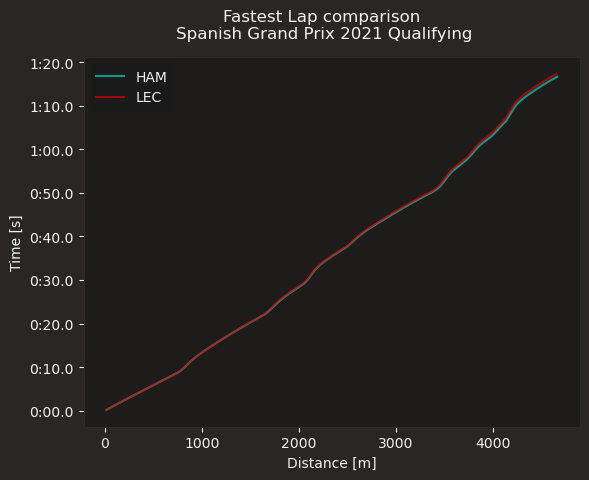

In [98]:
# get the team colors
fer_color = fastf1.plotting.team_color('FER')
mer_color = fastf1.plotting.team_color('MER')

# plot the time against distance for each driver using the telemetry data
fig, ax = plt.subplots()
ax.plot(ham_tel['Distance'], ham_tel['Time'], color=mer_color, label='HAM', alpha=0.7)
ax.plot(lec_tel['Distance'], lec_tel['Time'], color=fer_color, label='LEC', alpha = 0.7)

ax.set_xlabel('Distance [m]')
ax.set_ylabel('Time [s]')
ax.legend()
plt.suptitle(f'Fastest Lap comparison \n'
             f"{session.event.EventName} {session.event.year} Qualifying")
plt.show()